# aelm tutorial

First we import libraries that are to be used before or after running **aelm**

In [1]:
import os

import exma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In the **aelm** package we have a class that allows us to perform local minimization of accelerated exploration of local minima, we import it

In [2]:
from aelm import AELM

Now we have to add some files to our working directory: a lammps executable (lmp), a minimization input file (in.minimization) and a biased trajectory in xyz format (biased_traj.xyz). In this case, we also need a file with the reax force-field parameters (ffield.reax).

In [3]:
!ls

biased_traj.xyz  example.ipynb	ffield.reax  in.minimization  lmp


My lammps executable is compiled with OMP so I can define from here how many threads I want it to run on

In [4]:
os.environ["OMP_NUM_THREADS"] = "2"

We first read the trajectory using [exma](https://exma.readthedocs.io/en/latest/).

In [5]:
biased_traj = exma.read_xyz("biased_traj.xyz")

We can initializate the object with the class `AELM` where we specify the program which is going to be runned (LAMMPS), a list we the frames and some extra information of the simulation.

In [6]:
minimizations = AELM(
    "LAMMPS", 
    biased_traj, 
    {"box": np.full(3, 10.609089), "type": {"Si": 1, "Li": 2}}
)

Then, we can run each one of the minimizations by using a specific command of lammps and specifying the output files.

In [7]:
%%time
minimizations.run(
    "./lmp -in in.minimization -sf omp", 
    "log.lammps", 
    "in.frame", 
    "dump.minimization.lammpstrj",
    verbose=False,
)

CPU times: user 1.07 s, sys: 1.44 s, total: 2.5 s
Wall time: 35min 17s


We can access the energies through the `energies` property, which returns a `pd.DataFrame` with the columns corresponding to the initial and final energy of each structure.

In [8]:
df = minimizations.energies
df.head()

,initial,final
0,-4214.869629,-4516.891602
1,-4479.676270,-4758.495117
2,-4415.433594,-4775.907227
3,-4460.760254,-4817.204590
4,-4460.475586,-4814.914551


We can save this data to a csv file.

In [9]:
df.to_csv("example.csv", index=False)

In [10]:
!head -5 example.csv

initial,final
-4214.8696,-4516.8916
-4479.6763,-4758.495
-4415.4336,-4775.907
-4460.7603,-4817.2046


or plot a histogram to see the distribution of energies:

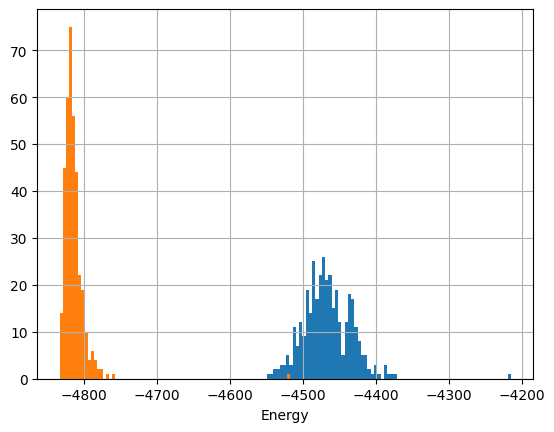

In [11]:
df.initial.hist(bins=75, label="initial")
df.final.hist(bins=75, label="final")

plt.xlabel("Energy")
plt.savefig("example.png", dpi=200)
plt.show()

In a similar way we can access to the atomic information of each one of the minimized frames.

In [12]:
min_traj = minimizations.minimized_frames

And we can save it in an xyz file for further analysis.

In [13]:
cell_info = {1: "Si", 2: "Li"}
for frame in min_traj:
    frame.types = [cell_info[t] for t in frame.types]
exma.write_xyz(min_traj, "minimizations.xyz")